<a href="https://colab.research.google.com/github/SatoshiEndoDEV/colab_sample/blob/main/signate_565music_LGBM%2BkNN_cv5%2Bpop10_region%2BTE_hm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LGBM+kNN


cv5に変更

FE追加
* popularityを10の位で分類しなおし、regionとgroupbyして集約特徴量を生成する
* 各特徴量を0.1刻みなどに丸めてみる


CVアンサンブルを調和平均に変更

target count encodingを追加

#signate CLI接続

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install signate

APIトークンを保存

In [3]:
! mkdir -p /root/.signate && cp /content/drive/MyDrive/signate/.signate/signate.json /root/.signate/

#ファイルダウンロード

In [4]:
! signate download -c 565

genre_labels.csv

sample_submit.csv

test.csv

train.csv


Download completed.


#ライブラリ

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

In [6]:
N_CLASSES = 11

In [7]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
df_sample_sub = pd.read_csv('/content/sample_submit.csv', header=None)
df_sample_sub.columns = ["index", "genre"]
df_genre_labels = pd.read_csv('/content/genre_labels.csv')

In [8]:
def merge_train_test(df_train, df_test):
    if "genre" not in df_test.columns.tolist():
        df_test["genre"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

In [9]:
def split_train_test(df):
    df_train = df[df["genre"] != -100]
    df_test = df[df["genre"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

In [10]:
df = merge_train_test(df_train, df_test)

#feature engineering



*   region+popularity10で集約
*   特徴項目を0.1刻みに分類



In [11]:
df['popularity10'] = df['popularity']//10

In [12]:
origin = ['duration_ms',
         'acousticness',
         'positiveness',
         'danceability',
         'loudness',
         'energy',
         'liveness',
         'speechiness',
         'instrumentalness',
]

In [13]:
for o in origin:
    df[f"{o}_mean"] = df.groupby(["region", "popularity10"]).transform(np.mean)[f"{o}"]
    df[f"{o}_median"] = df.groupby(["region", "popularity10"]).transform(np.median)[f"{o}"]
    df[f"{o}_max"] = df.groupby(["region", "popularity10"]).transform(np.max)[f"{o}"]
    df[f"{o}_min"] = df.groupby(["region", "popularity10"]).transform(np.min)[f"{o}"]
    df[f"{o}_25"] = df.groupby(["region", "popularity10"]).transform(lambda x: np.percentile(x, q=0.25))[f"{o}"]
    df[f"{o}_75"] = df.groupby(["region", "popularity10"]).transform(lambda x: np.percentile(x, q=0.75))[f"{o}"]
    df[f"{o}_zscore"] = df.groupby(["region", "popularity10"]).transform(lambda x: (x-np.mean(x))/np.std(x))[f"{o}"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  
/usr/local/lib/pyt

In [14]:
origin10 = ['duration_ms',
         'acousticness',
         'positiveness',
         'danceability',
         'energy',
         'liveness',
         'speechiness',
         'instrumentalness',
]

In [15]:
for o in origin10:
    exec(f'df["{o+str(10)}"]=df["{o}"]//0.1')

In [16]:
df["loudness10"] = round(np.abs(df["loudness"]))

target count encoding

In [17]:
#genreでone hot encoding
ohe = pd.get_dummies(df['genre'], prefix='genre')

In [18]:
#genre_-100は使用しないので削除
ohe.drop(['genre_-100'], axis =1, inplace=True)

In [19]:
df = df.join(ohe)

In [20]:
#genre_1 ,,, でカウント
for i in range(11):
    df[f'genre_{i}_tce'] = df.groupby(["region", "popularity10"]).transform(np.sum)[f'genre_{i}'].astype('int')

In [21]:
for j in range(11):
    df.drop([f'genre_{j}'], axis=1, inplace=True)

testにもtceが反映されているのでリークかも

kNN特徴量生成

In [22]:
df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))

In [23]:
df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)

In [24]:
df = pd.concat([df, pd.get_dummies(df["region"]).rename(columns={"unknown": "region_unknown"})], axis=1)

In [25]:
df["num_nans"] = 0
for col in [
    "acousticness",
    "positiveness",
    "danceability",
    "energy",
    "liveness",
    "speechiness",
    "instrumentalness",
]:
    df["num_nans"] += df[col].isna()

In [26]:
class CountEncoder:
    def fit(self, series):
        self.counts = series.groupby(series).count()
        return self
    
    def transform(self, series):
        return series.map(self.counts).fillna(0)
    
    def fit_transform(self, series):
        return self.fit(series).transform(series)

In [27]:
columns_count_enc = ["region"]
for col in columns_count_enc:
    df["countenc_" + col] = CountEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, "countenc_" + col] = np.nan

In [28]:
columns_label_enc = ["region"]
for col in columns_count_enc:
    df["labelenc_" + col] = LabelEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, "labelenc_" + col] = np.nan

In [29]:
class GroupFeatureExtractor:  # 参考: https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    EX_TRANS_METHODS = ["deviation", "zscore"]
    
    def __init__(self, group_key, group_values, agg_methods):
        self.group_key = group_key
        self.group_values = group_values

        self.ex_trans_methods = [m for m in agg_methods if m in self.EX_TRANS_METHODS]
        self.agg_methods = [m for m in agg_methods if m not in self.ex_trans_methods]
        self.df_agg = None

    def fit(self, df_train, y=None):
        if not self.agg_methods:
            return
        dfs = []
        for agg_method in self.agg_methods:
            if callable(agg_method):
                agg_method_name = agg_method.__name__
            else:
                agg_method_name = agg_method
            df_agg = (df_train[[self.group_key] + self.group_values].groupby(self.group_key).agg(agg_method))
            df_agg.columns = self._get_column_names(agg_method_name)
            dfs.append(df_agg)
        self.df_agg = pd.concat(dfs, axis=1).reset_index()

    def transform(self, df_eval):
        key = self.group_key
        if self.agg_methods:
            df_features = pd.merge(df_eval[[self.group_key]], self.df_agg, on=self.group_key, how="left")
        else:
            df_features = df_eval[[self.group_key]].copy()
        if self.ex_trans_methods:
            if "deviation" in self.ex_trans_methods:
                df_features[self._get_agg_column_names("deviation")] = df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")
            if "zscore" in self.ex_trans_methods:
                df_features[self._get_column_names("zscore")] = (df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")) \
                                                                / (df_eval[[key]+self.group_values].groupby(key).transform("std") + 1e-8)
        df_features.drop(self.group_key, axis=1, inplace=True)
        return df_features

    def _get_column_names(self, method):
        return [f"agg_{method}_{col}_grpby_{self.group_key}" for col in self.group_values]

    def fit_transform(self, df_train, y=None):
        self.fit(df_train, y=y)
        return self.transform(df_train) 

In [30]:
df["log_tempo"] = np.log(df["tempo"])

In [31]:
gfe = GroupFeatureExtractor(
    "region", 
    ['popularity', 'duration_ms', 'acousticness', 'positiveness', 'danceability', 'loudness', 'energy', 'liveness', 'speechiness', 'instrumentalness', 'log_tempo'],
    ["zscore"]
)

In [32]:
df = pd.concat([df, gfe.fit_transform(df)], axis=1)

In [33]:
class KNNFeatureExtractor:
    def __init__(self, n_neighbors=5):
        self.knn = KNeighborsClassifier(n_neighbors + 1)
    
    def fit(self, X, y):
        self.knn.fit(X, y)
        self.y = y if isinstance(y, np.ndarray) else np.array(y)
        return self
    
    def transform(self, X, is_train_data):
        distances, indexes = self.knn.kneighbors(X)
        distances = distances[:, 1:] if is_train_data else distances[:, :-1]
        indexes = indexes[:, 1:] if is_train_data else indexes[:, :-1]
        labels = self.y[indexes]
        score_columns = [f"knn_score_class{c:02d}" for c in range(N_CLASSES)]
        df_knn = pd.DataFrame(
            [np.bincount(labels_, distances_, N_CLASSES) for labels_, distances_ in zip(labels, 1.0 / distances)],
            columns=score_columns
        )
        df_knn["max_knn_scores"] = df_knn.max(1)
        for col in score_columns:
            df_knn[f"sub_max_knn_scores_{col}"] = df_knn["max_knn_scores"] - df_knn[col]
        for i, col1 in enumerate(score_columns):
            for j, col2 in enumerate(score_columns[i+1:], i+1):
                if {i, j} & {8, 10}:
                    df_knn[f"sub_{col1}_{col2}"] = df_knn[col1] - df_knn[col2]
        df_knn["sum_knn_scores"] = df_knn.sum(1)
        
        return df_knn

feature scaling

In [34]:
df["log_tempo"] = np.log(df["tempo"])
for col in [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 'log_tempo', 'num_nans',
]:
    df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]

In [35]:
df_train, df_test = split_train_test(df)

In [36]:
target = df_train["genre"]

#parameters

In [37]:
learning_rate = 0.01

In [38]:
lgb_params = {
    "objective": "multiclass",
    "num_class": N_CLASSES,
    #"metric": "None",
    "learning_rate": learning_rate,
    "num_leaves": 3,
    "min_data_in_leaf": 40,
    #"colsample_bytree": 1.0,
    #"feature_fraction": 1.0,
    #"bagging_freq": 0,
    #"bagging_fraction": 1.0,
    "verbosity": 0,
    "seed": 42,
}

In [39]:
knn_n_neighbors = 10

In [40]:
knn_features = [
   'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'region_unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'standardscaled_log_tempo', 'standardscaled_num_nans'
]

In [41]:
dict_feature_weights = {}
for col in [
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
    'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
    'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
    'region_S', 'region_T', 'region_unknown'
]:
    dict_feature_weights[col] = 100.0

In [42]:
for col in [
    'standardscaled_duration_ms',
    'standardscaled_acousticness', 'standardscaled_positiveness',
    'standardscaled_danceability', 'standardscaled_loudness',
    'standardscaled_energy', 'standardscaled_liveness',
    'standardscaled_speechiness', 'standardscaled_instrumentalness'
]:
    dict_feature_weights[col] = 1.0

In [43]:
dict_feature_weights["standardscaled_popularity"] = 8.0
dict_feature_weights["standardscaled_log_tempo"] = 0.001
dict_feature_weights["standardscaled_num_nans"] = 100.0

In [44]:
knn_feature_weights = np.array([dict_feature_weights[col] for col in knn_features])

In [45]:
N_SPLITS = 5
SEED_SKF = 42
np.random.seed(42)

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
oof = np.zeros((len(df_train), N_CLASSES))
predictions = np.zeros((len(df_test), N_CLASSES))
df_feature_importance = pd.DataFrame()


features_categorical = ["labelenc_region"]
#features = features_numerical + features_categorical

for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
    print(f"------------------------------ fold {fold_} ------------------------------")
    
    df_trn = df_train.loc[indexes_trn,:].reset_index(drop=True)
    df_val = df_train.loc[indexes_val,:].reset_index(drop=True)
    target_trn = target[indexes_trn].reset_index(drop=True)
    target_val = target[indexes_val].reset_index(drop=True)
    
    # make knn features
    X = df_trn[knn_features].fillna(0.0).values * knn_feature_weights
    knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(X, target_trn)
    df_trn = pd.concat([df_trn, knn_feature_extractor.transform(X, is_train_data=True)], axis=1)
    X = df_val[knn_features].fillna(0.0).values * knn_feature_weights
    df_val = pd.concat([df_val, knn_feature_extractor.transform(X, is_train_data=False)], axis=1)
    X = df_test[knn_features].fillna(0.0).values * knn_feature_weights
    df_test_knn_features = knn_feature_extractor.transform(X, is_train_data=False)
    for col in df_test_knn_features.columns:
        df_test[col] = df_test_knn_features[col]
    
    
    features = df_trn.columns.tolist()
    features.remove("index")
    features.remove("genre")
    features.remove("region")
    features.remove("genre_name")


    lgb_train = lgb.Dataset(
        df_trn.loc[:, features],
        label=target_trn,
        feature_name=features,
        categorical_feature=features_categorical
    )
    lgb_valid = lgb.Dataset(
        df_val.loc[:, features],
        label=target_val,
        feature_name=features,
        categorical_feature=features_categorical
    )
    
    lgb_params["learning_rate"] = learning_rate + np.random.random() * 0.001  # おまじない
    num_round = 999999999
    model = lgb.train(
        lgb_params,
        lgb_train, 
        num_round, 
        valid_sets=[lgb_train, lgb_valid], 
        verbose_eval=300,
        early_stopping_rounds=300 if num_round >= 1e8 else None,
        fobj=None,
        #feval=lgb_metric,
    )
    
    # cv
    prediction_round = model.best_iteration+150 if num_round >= 1e8 else num_round  # おまじない
    oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)
    
    # feature importance
    df_fold_importance = pd.DataFrame()
    df_fold_importance["feature"] = features
    df_fold_importance["importance"] = model.feature_importance()
    df_fold_importance["fold"] = fold_
    df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)
    
    # prediction for test data
    p = model.predict(df_test[features], num_iteration=prediction_round)
    predictions +=  1/p

predictions = N_SPLITS / predictions
print()

------------------------------ fold 0 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.791645	valid_1's multi_logloss: 0.855218
[600]	training's multi_logloss: 0.682703	valid_1's multi_logloss: 0.783223
[900]	training's multi_logloss: 0.629452	valid_1's multi_logloss: 0.767621
[1200]	training's multi_logloss: 0.591246	valid_1's multi_logloss: 0.763972
[1500]	training's multi_logloss: 0.55988	valid_1's multi_logloss: 0.765304
Early stopping, best iteration is:
[1216]	training's multi_logloss: 0.58943	valid_1's multi_logloss: 0.763818
------------------------------ fold 1 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.789974	valid_1's multi_logloss: 0.836741
[600]	training's multi_logloss: 0.68482	valid_1's multi_logloss: 0.757709
[900]	training's multi_logloss: 0.630155	valid_1's multi_logloss: 0.740898
[1200]	training's multi_logloss: 0.590752	valid_1's multi_logloss: 0.733977
[1500]	training's multi_logloss: 0.558087	valid_1's multi_logloss: 0.729852
[1800]	training's multi_logloss: 0.529808	valid_1's multi_logloss: 0.728956
Early stopping, best iteration is:
[1721]	training's multi_logloss: 0.536983	valid_1's multi_logloss: 0.728606
------------------------------ fold 2 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.784097	valid_1's multi_logloss: 0.861861
[600]	training's multi_logloss: 0.676684	valid_1's multi_logloss: 0.784527
[900]	training's multi_logloss: 0.62224	valid_1's multi_logloss: 0.767488
[1200]	training's multi_logloss: 0.582077	valid_1's multi_logloss: 0.764151
[1500]	training's multi_logloss: 0.548634	valid_1's multi_logloss: 0.76286
[1800]	training's multi_logloss: 0.519998	valid_1's multi_logloss: 0.764017
Early stopping, best iteration is:
[1534]	training's multi_logloss: 0.545175	valid_1's multi_logloss: 0.762744
------------------------------ fold 3 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.793009	valid_1's multi_logloss: 0.820979
[600]	training's multi_logloss: 0.6855	valid_1's multi_logloss: 0.741954
[900]	training's multi_logloss: 0.629622	valid_1's multi_logloss: 0.725261
[1200]	training's multi_logloss: 0.58879	valid_1's multi_logloss: 0.721128
[1500]	training's multi_logloss: 0.554863	valid_1's multi_logloss: 0.720635
Early stopping, best iteration is:
[1425]	training's multi_logloss: 0.562735	valid_1's multi_logloss: 0.720489
------------------------------ fold 4 ------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.7852	valid_1's multi_logloss: 0.885571
[600]	training's multi_logloss: 0.67538	valid_1's multi_logloss: 0.808866
[900]	training's multi_logloss: 0.619989	valid_1's multi_logloss: 0.792102
[1200]	training's multi_logloss: 0.580622	valid_1's multi_logloss: 0.786652
[1500]	training's multi_logloss: 0.548811	valid_1's multi_logloss: 0.787578
Early stopping, best iteration is:
[1294]	training's multi_logloss: 0.570131	valid_1's multi_logloss: 0.786162



CV score
  f1:  0.64528

              precision    recall  f1-score   support

           0       0.80      0.62      0.70        32
           1       0.56      0.37      0.44       205
           2       0.71      0.50      0.59       191
           3       0.78      0.76      0.77       362
           4       0.69      0.53      0.60        45
           5       0.63      0.52      0.57       126
           6       0.45      0.36      0.40        50
           7       0.67      0.62      0.64       334
           8       0.72      0.80      0.76      1305
           9       0.80      0.86      0.83        59
          10       0.78      0.81      0.79      1337

    accuracy                           0.73      4046
   macro avg       0.69      0.62      0.65      4046
weighted avg       0.73      0.73      0.73      4046



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


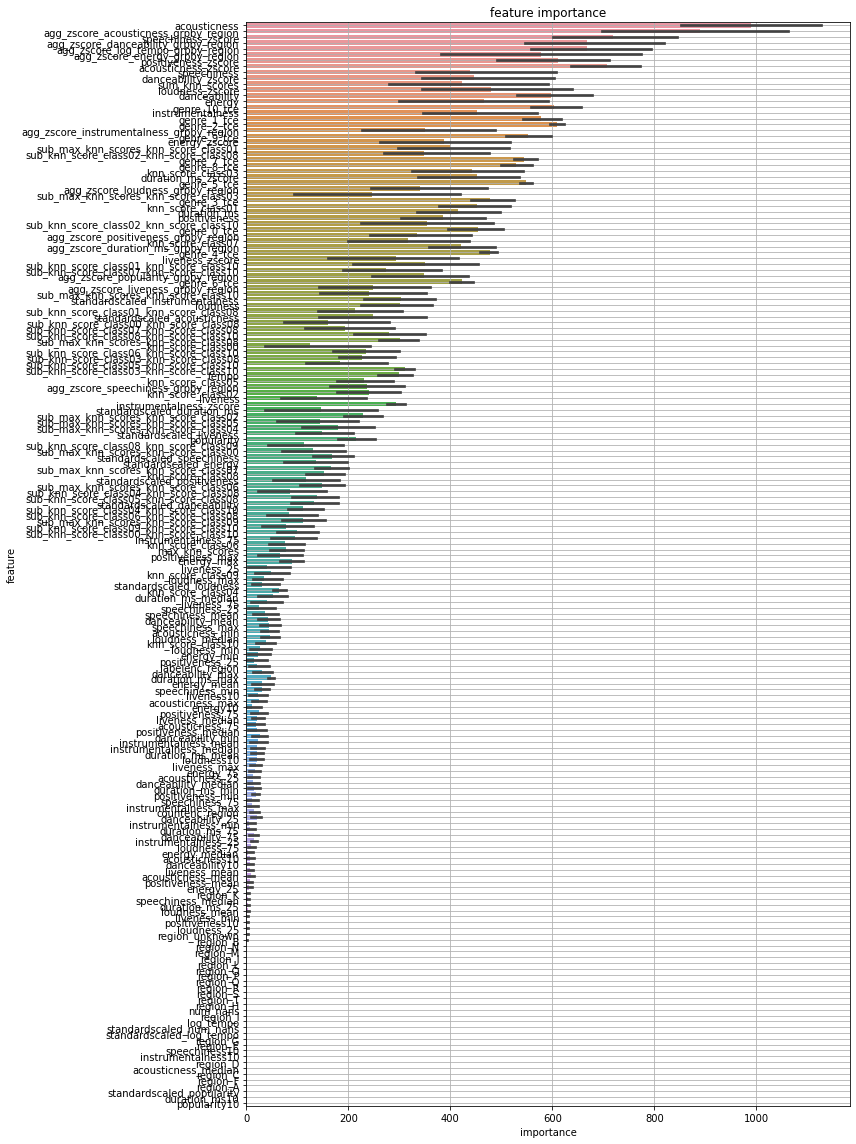

In [46]:
df_test["prediction"] = predictions.argmax(1)
score = f1_score(target, oof.argmax(1), average="macro")
print("CV score")
print(f"  f1: {score:8.5f}")
print()
print(classification_report(target, oof.argmax(1)))

plt.figure(figsize=(12, 16))
sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
plt.title("feature importance")
plt.grid()
plt.tight_layout()
plt.show()

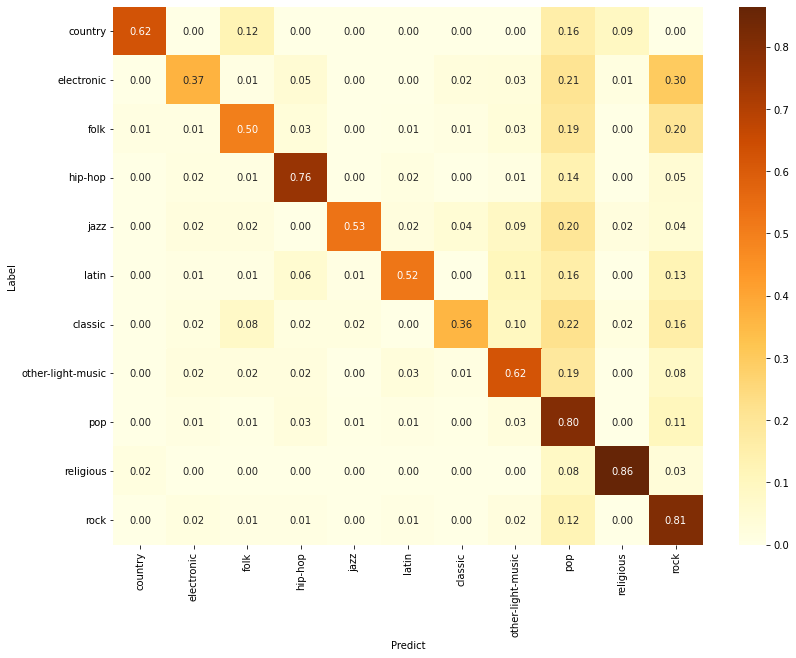

In [47]:
def visualize_confusion_matrix(y_true,
                               pred_label,
                               height=.6,
                               labels=None):  # from https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 2, size * 1.5))
    sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    return fig

oof_label = pd.Series(np.argmax(oof, axis=1))
fig = visualize_confusion_matrix(y_true=target, pred_label=oof_label, labels=df_genre_labels["genre"])
fig.show()

#サブミット

In [48]:
df_submission = df_sample_sub.copy()
df_submission["genre"] = df_submission["index"].map(dict(df_test[["index", "prediction"]].values))
assert not df_submission["genre"].isna().any()
display(df_submission.head(10))

# make submission file
df_submission.to_csv("submit-lgbm+kNN-cv5+pop10*region+TE-hm.csv", header=None, index=False)

,index,genre
0,4046,7
1,4047,10
2,4048,10
3,4049,8
4,4050,8
5,4051,7
6,4052,8
7,4053,4
8,4054,3
9,4055,10


In [49]:
! signate submit -c 565 -n "lgbm+kNN cv5 neibor=10 pop10*region + feature//10 cv + target count encoding as hearmonic mean" submit-lgbm+kNN-cv5+pop10*region+TE-hm.csv

You have successfully submitted your predictions.We will send you the submission result to your email address.
